In [1]:
# 1. Bibliotekų importavimas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import joblib
from datetime import datetime, timedelta
import requests
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Nustatome grafikų stilių
plt.style.use('ggplot')

# Pridedame projekto pagrindinį katalogą į kelią, kad galėtume importuoti modulius
sys.path.append('../..')

In [2]:
# 2. Duomenų gavimas iš Binance API
# Naudojame tą pačią funkciją, kaip ir ankstesniuose modeliuose

def gauti_bitcoin_duomenis(dienu_skaicius=365):
    """
    Gauna Bitcoin kainos duomenis per pasirinktą dienų skaičių iš Binance
    
    Args:
        dienu_skaicius: Kiek praeities dienų įtraukti
    
    Returns:
        pandas DataFrame su kainų duomenimis
    """
    # Apskaičiuojame pradžios laiko žymą (timestamp) milisekundėmis
    pabaigos_data = datetime.now()
    pradzios_data = pabaigos_data - timedelta(days=dienu_skaicius)
    
    # Konvertuojame į UNIX laiko žymą milisekundėmis
    pradzios_ms = int(pradzios_data.timestamp() * 1000)
    
    # Binance API URL - naudojame dienos (1d) laiko intervalą BTCUSDT simboliui
    url = "https://api.binance.com/api/v3/klines"
    
    # Parametrai užklausai
    params = {
        "symbol": "BTCUSDT",     # Bitcoin/USDT pora
        "interval": "1d",        # Dieninis intervalas
        "startTime": pradzios_ms, # Pradžios laikas
        "limit": 1000            # Maksimalus įrašų skaičius (Binance limitas)
    }
    
    print(f"Gaunami Bitcoin duomenys nuo {pradzios_data.strftime('%Y-%m-%d')} iki {pabaigos_data.strftime('%Y-%m-%d')}...")
    
    try:
        # Siunčiame užklausą į Binance API
        atsakymas = requests.get(url, params=params)
        
        # Tikriname, ar užklausa sėkminga
        if atsakymas.status_code == 200:
            duomenys = atsakymas.json()
            
            # Sukuriame DataFrame su reikiamais stulpeliais
            df = pd.DataFrame(duomenys, columns=[
                'atidarymo_laikas', 'atidarymo_kaina', 'auksciausia', 'zemiausia', 
                'uzdarymo_kaina', 'apyvarta', 'uzdarymo_laikas', 'apyvarta_quote', 
                'sandoriu_skaicius', 'aktyvaus_pirkimo_apyvarta', 
                'aktyvaus_pirkimo_apyvarta_quote', 'ignoruoti'
            ])
            
            # Konvertuojame laiko žymas į datetime ir kainų stulpelius į float
            df['atidarymo_laikas'] = pd.to_datetime(df['atidarymo_laikas'], unit='ms')
            df['uzdarymo_laikas'] = pd.to_datetime(df['uzdarymo_laikas'], unit='ms')
            df['uzdarymo_kaina'] = df['uzdarymo_kaina'].astype(float)
            
            # Nustatome datą kaip indeksą
            df = df.set_index('atidarymo_laikas')
            
            # Išrenkame tik uždarymo kainą ir pervadinkime stulpelį
            bitcoin_df = df[['uzdarymo_kaina']].copy()
            bitcoin_df = bitcoin_df.rename(columns={'uzdarymo_kaina': 'kaina'})
            
            print(f"Sėkmingai gauti {len(bitcoin_df)} dienų duomenys.")
            return bitcoin_df
            
        else:
            print(f"Klaida gaunant duomenis iš Binance. Statusas: {atsakymas.status_code}")
            print(f"Atsakymas: {atsakymas.text}")
            return None
            
    except Exception as e:
        print(f"Klaida: {str(e)}")
        return None

# Gauname duomenis už pastaruosius 2 metus (730 dienų) 
# Šiuos duomenis naudosime modelių vertinimui
bitcoin_df = gauti_bitcoin_duomenis(730)
bitcoin_df = bitcoin_df.dropna()  # Pašaliname eilutes su trūkstamomis reikšmėmis

Gaunami Bitcoin duomenys nuo 2023-05-24 iki 2025-05-23...
Sėkmingai gauti 730 dienų duomenys.


In [3]:
# 3. Duomenų paruošimas modelių vertinimui

def paruosti_modeliu_ypatybes(bitcoin_df):
    """
    Paruošia duomenis su visomis ypatybėmis, reikalingomis modeliams
    
    Args:
        bitcoin_df: DataFrame su Bitcoin kainų duomenimis
    
    Returns:
        DataFrame su visomis modeliams reikalingomis ypatybėmis
    """
    # Kopijuojame duomenis, kad originalas liktų nepakitęs
    df = bitcoin_df.copy()
    
    # Sukuriame tikslo kintamąjį - ar kaina pakils (1) ar nukris (0) kitą dieną
    df['kaina_rytoj'] = df['kaina'].shift(-1)  # Kainos reikšmė kitą dieną
    df['tikslas'] = (df['kaina_rytoj'] > df['kaina']).astype(int)  # 1 jei kils, 0 jei kris
    
    # 1. Ankstesnių dienų kainų pokyčiai
    df['pokytis_1d'] = df['kaina'].pct_change(1)  # Pokytis per 1 dieną
    df['pokytis_3d'] = df['kaina'].pct_change(3)  # Pokytis per 3 dienas
    df['pokytis_7d'] = df['kaina'].pct_change(7)  # Pokytis per 7 dienas
    df['pokytis_14d'] = df['kaina'].pct_change(14)  # Pokytis per 14 dienų
    
    # 2. Slankieji vidurkiai
    df['SMA_7'] = df['kaina'].rolling(window=7).mean()  # 7 dienų slankusis vidurkis
    df['SMA_30'] = df['kaina'].rolling(window=30).mean()  # 30 dienų slankusis vidurkis
    df['SMA_50'] = df['kaina'].rolling(window=50).mean()  # 50 dienų slankusis vidurkis
    
    # 3. Kainos ir slankiojo vidurkio santykis
    df['santykis_SMA7'] = df['kaina'] / df['SMA_7']
    df['santykis_SMA30'] = df['kaina'] / df['SMA_30']
    
    # 4. RSI (Relative Strength Index)
    def skaiciuoti_rsi(kainos, periodas=14):
        # Apskaičiuojame kainos pokyčius
        delta = kainos.diff()
        
        # Atskirame teigiamus ir neigiamus pokyčius
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        # Apskaičiuojame vidutinį pelną ir nuostolį per periodą
        avg_gain = gain.rolling(window=periodas).mean()
        avg_loss = loss.rolling(window=periodas).mean()
        
        # Apskaičiuojame santykinį stiprumo indeksą (RS)
        rs = avg_gain / avg_loss
        
        # Apskaičiuojame RSI
        rsi = 100 - (100 / (1 + rs))
        
        return rsi
    
    df['RSI_14'] = skaiciuoti_rsi(df['kaina'])
    df['RSI_7'] = skaiciuoti_rsi(df['kaina'], 7)
    
    # 5. Kainų svyravimų ypatybės
    df['svyravimas_7d'] = df['kaina'].rolling(window=7).std() / df['kaina'].rolling(window=7).mean()
    df['svyravimas_30d'] = df['kaina'].rolling(window=30).std() / df['kaina'].rolling(window=30).mean()
    
    # 6. MACD (Moving Average Convergence Divergence)
    df['EMA_12'] = df['kaina'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['kaina'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    # Pašaliname eilutes su trūkstamomis reikšmėmis
    df = df.dropna()
    
    # Pašaliname 'kaina_rytoj' stulpelį, nes jo negalime naudoti kaip ypatybės
    df = df.drop('kaina_rytoj', axis=1)
    
    return df

# Paruošiame duomenis su visomis ypatybėmis
paruosti_duomenys = paruosti_modeliu_ypatybes(bitcoin_df)

# Padalijame duomenis į mokymui ir testavimui (60% mokymui, 40% testavimui)
# Naudojame didesnį testavimo rinkinį prekybos simuliacijai
mokymo_dalis = int(len(paruosti_duomenys) * 0.6)

# Mokymui naudojame ankstesnius duomenis
mokymo_duomenys = paruosti_duomenys.iloc[:mokymo_dalis]
# Testavimui naudojame vėlesnius duomenis
testavimo_duomenys = paruosti_duomenys.iloc[mokymo_dalis:]

print(f"Mokymo duomenų dydis: {len(mokymo_duomenys)}")
print(f"Testavimo duomenų dydis: {len(testavimo_duomenys)}")

# Paruošiame X ir y mokymui
X_train = mokymo_duomenys.drop('tikslas', axis=1)
y_train = mokymo_duomenys['tikslas']

# Paruošiame X ir y testavimui
X_test = testavimo_duomenys.drop('tikslas', axis=1)
y_test = testavimo_duomenys['tikslas']

Mokymo duomenų dydis: 408
Testavimo duomenų dydis: 272


In [4]:
# 4. Prekybos simuliatoriaus klasė

class PrekybosTesteris:
    """
    Prekybos simuliatorius, kuris testuoja modelio prognozes su istoriniais duomenimis
    """
    def __init__(self, pradinis_kapitalas=10000.0, komisinis_mokestis=0.001):
        self.pradinis_kapitalas = pradinis_kapitalas
        self.komisinis_mokestis = komisinis_mokestis  # 0.1% komisinis mokestis
        self.kapitalas = pradinis_kapitalas
        self.btc_kiekis = 0.0
        self.sandoriai = []
        
    def atlikti_testavima(self, duomenys, prognozes, strategija='signal_change'):
        """
        Testuoja prekybos strategiją su istoriniais duomenimis
        
        Args:
            duomenys: DataFrame su istoriniais kainos duomenimis
            prognozes: Modelio prognozės (0 - kaina kris, 1 - kaina kils)
            strategija: Prekybos strategijos tipas ('signal_change' arba 'daily')
        
        Returns:
            DataFrame su prekybos rezultatais
        """
        # Nustatome pradinę būseną
        self.kapitalas = self.pradinis_kapitalas
        self.btc_kiekis = 0.0
        self.sandoriai = []
        
        # Sukuriame rezultatų DataFrame
        rezultatai = pd.DataFrame({
            'data': duomenys.index,
            'kaina': duomenys['kaina'],
            'prognoze': prognozes
        })
        
        # Pridedame stulpelius sandoriams ir portfelio vertei
        rezultatai['veiksmas'] = 'laukti'
        rezultatai['btc_kiekis'] = 0.0
        rezultatai['kapitalas_usd'] = self.pradinis_kapitalas
        rezultatai['portfelio_verte'] = self.pradinis_kapitalas
        rezultatai['graza_proc'] = 0.0
        
        # Prekybos strategija:
        # 'signal_change': Prekiaujame tik kai pasikeičia signalas (rekomenduojama)
        # 'daily': Prekiaujame kiekvieną dieną pagal prognozę
        
        for i in range(len(rezultatai)):
            # Dabartinė kaina ir prognozė
            kaina = rezultatai.iloc[i]['kaina']
            prognoze = rezultatai.iloc[i]['prognoze']
            
            # Sprendimas dėl veiksmo, priklausomai nuo strategijos
            if strategija == 'signal_change' and i > 0:
                ankstesne_prognoze = rezultatai.iloc[i-1]['prognoze']
                
                # Jei prognozė pasikeitė iš 0 į 1 (prognozuojame kilimą) - perkame
                if ankstesne_prognoze == 0 and prognoze == 1:
                    # Perkame BTC už visą turimą kapitalą
                    if self.kapitalas > 0:
                        # Atskaičiuojame komisinį mokestį
                        mokestis = self.kapitalas * self.komisinis_mokestis
                        suma_pirkimui = self.kapitalas - mokestis
                        
                        btc_pirkimui = suma_pirkimui / kaina  # Kiek BTC galime nupirkti
                        self.btc_kiekis += btc_pirkimui
                        self.kapitalas = 0
                        rezultatai.iloc[i, rezultatai.columns.get_loc('veiksmas')] = 'pirkti'
                        
                        # Įrašome sandorį
                        self.sandoriai.append({
                            'data': rezultatai.index[i],
                            'veiksmas': 'pirkti',
                            'kaina': kaina,
                            'kiekis': btc_pirkimui,
                            'suma': suma_pirkimui,
                            'mokestis': mokestis
                        })
                
                # Jei prognozė pasikeitė iš 1 į 0 (prognozuojame kritimą) - parduodame
                elif ankstesne_prognoze == 1 and prognoze == 0:
                    # Parduodame visą turimą BTC
                    if self.btc_kiekis > 0:
                        bendra_suma = self.btc_kiekis * kaina
                        mokestis = bendra_suma * self.komisinis_mokestis
                        gryna_suma = bendra_suma - mokestis
                        
                        self.kapitalas += gryna_suma
                        pardavimo_kiekis = self.btc_kiekis
                        self.btc_kiekis = 0
                        rezultatai.iloc[i, rezultatai.columns.get_loc('veiksmas')] = 'parduoti'
                        
                        # Įrašome sandorį
                        self.sandoriai.append({
                            'data': rezultatai.index[i],
                            'veiksmas': 'parduoti',
                            'kaina': kaina,
                            'kiekis': pardavimo_kiekis,
                            'suma': gryna_suma,
                            'mokestis': mokestis
                        })
            
            elif strategija == 'daily':
                # Kasdienė strategija - perkame jei prognozė 1, parduodame jei 0
                if prognoze == 1 and self.kapitalas > 0:
                    # Perkame BTC
                    mokestis = self.kapitalas * self.komisinis_mokestis
                    suma_pirkimui = self.kapitalas - mokestis
                    
                    btc_pirkimui = suma_pirkimui / kaina
                    self.btc_kiekis += btc_pirkimui
                    self.kapitalas = 0
                    rezultatai.iloc[i, rezultatai.columns.get_loc('veiksmas')] = 'pirkti'
                    
                    # Įrašome sandorį
                    self.sandoriai.append({
                        'data': rezultatai.index[i],
                        'veiksmas': 'pirkti',
                        'kaina': kaina,
                        'kiekis': btc_pirkimui,
                        'suma': suma_pirkimui,
                        'mokestis': mokestis
                    })
                
                elif prognoze == 0 and self.btc_kiekis > 0:
                    # Parduodame BTC
                    bendra_suma = self.btc_kiekis * kaina
                    mokestis = bendra_suma * self.komisinis_mokestis
                    gryna_suma = bendra_suma - mokestis
                    
                    self.kapitalas += gryna_suma
                    pardavimo_kiekis = self.btc_kiekis
                    self.btc_kiekis = 0
                    rezultatai.iloc[i, rezultatai.columns.get_loc('veiksmas')] = 'parduoti'
                    
                    # Įrašome sandorį
                    self.sandoriai.append({
                        'data': rezultatai.index[i],
                        'veiksmas': 'parduoti',
                        'kaina': kaina,
                        'kiekis': pardavimo_kiekis,
                        'suma': gryna_suma,
                        'mokestis': mokestis
                    })
            
            # Atnaujinama BTC kiekis ir portfelio vertė
            rezultatai.iloc[i, rezultatai.columns.get_loc('btc_kiekis')] = self.btc_kiekis
            rezultatai.iloc[i, rezultatai.columns.get_loc('kapitalas_usd')] = self.kapitalas
            
            # Apskaičiuojame bendrą portfelio vertę (kapitalas + BTC vertė)
            portfelio_verte = self.kapitalas + (self.btc_kiekis * kaina)
            rezultatai.iloc[i, rezultatai.columns.get_loc('portfelio_verte')] = portfelio_verte
            
            # Apskaičiuojame grąžą nuo pradžios
            if i > 0:
                pradine_verte = self.pradinis_kapitalas
                dabartine_verte = portfelio_verte
                graza_proc = ((dabartine_verte - pradine_verte) / pradine_verte) * 100
                rezultatai.iloc[i, rezultatai.columns.get_loc('graza_proc')] = graza_proc
        
        # Paskutinis pardavimas periodo pabaigoje (jei dar turime BTC)
        if self.btc_kiekis > 0:
            # Parduodame visą likusį BTC paskutine kaina
            paskutine_kaina = rezultatai.iloc[-1]['kaina']
            bendra_suma = self.btc_kiekis * paskutine_kaina
            mokestis = bendra_suma * self.komisinis_mokestis
            gryna_suma = bendra_suma - mokestis
            
            self.kapitalas += gryna_suma
            self.btc_kiekis = 0
            
            # Atnaujinama paskutinė eilutė
            rezultatai.iloc[-1, rezultatai.columns.get_loc('veiksmas')] = 'parduoti (pabaiga)'
            rezultatai.iloc[-1, rezultatai.columns.get_loc('btc_kiekis')] = 0
            rezultatai.iloc[-1, rezultatai.columns.get_loc('kapitalas_usd')] = self.kapitalas
            rezultatai.iloc[-1, rezultatai.columns.get_loc('portfelio_verte')] = self.kapitalas
            
            # Įrašome sandorį
            self.sandoriai.append({
                'data': rezultatai.index[-1],
                'veiksmas': 'parduoti (pabaiga)',
                'kaina': paskutine_kaina,
                'kiekis': self.btc_kiekis,
                'suma': gryna_suma,
                'mokestis': mokestis
            })
        
        return rezultatai
    
    def apskaiciuoti_metrikas(self, rezultatai):
        """
        Apskaičiuoja įvairias prekybos strategijos metrikas
        
        Args:
            rezultatai: DataFrame su prekybos rezultatais
        
        Returns:
            Dictionary su metrikomis
        """
        # Pagrindinės metrikos
        pradine_verte = self.pradinis_kapitalas
        galutine_verte = rezultatai.iloc[-1]['portfelio_verte']
        bendras_pelnas = galutine_verte - pradine_verte
        pelno_procentas = (bendras_pelnas / pradine_verte) * 100
        
        # Sandorių skaičius
        pirkimu_sk = rezultatai[rezultatai['veiksmas'] == 'pirkti'].shape[0]
        pardavimu_sk = rezultatai[rezultatai['veiksmas'].str.contains('parduoti')].shape[0]
        sandoriu_sk = pirkimu_sk + pardavimu_sk
        
        # Sėkmingų sandorių skaičius (pelningi pardavimai)
        pelningi_sandoriai = 0
        nuostolingi_sandoriai = 0
        bendras_pelnas_sandoriai = 0
        bendras_nuostolis_sandoriai = 0
        
        # Sukuriame sandorių porų sąrašą (pirkimas-pardavimas)
        poros = []
        if len(self.sandoriai) > 1:
            i = 0
            while i < len(self.sandoriai) - 1:
                if self.sandoriai[i]['veiksmas'] == 'pirkti' and 'parduoti' in self.sandoriai[i+1]['veiksmas']:
                    pirkimo_kaina = self.sandoriai[i]['kaina']
                    pardavimo_kaina = self.sandoriai[i+1]['kaina']
                    pirkimo_suma = self.sandoriai[i]['suma']
                    pardavimo_suma = self.sandoriai[i+1]['suma']
                    
                    pora_pelnas = pardavimo_suma - pirkimo_suma
                    pora_pelnas_proc = (pora_pelnas / pirkimo_suma) * 100
                    
                    poros.append({
                        'pirkimo_data': self.sandoriai[i]['data'],
                        'pardavimo_data': self.sandoriai[i+1]['data'],
                        'pirkimo_kaina': pirkimo_kaina,
                        'pardavimo_kaina': pardavimo_kaina,
                        'pelnas': pora_pelnas,
                        'pelnas_proc': pora_pelnas_proc
                    })
                    
                    if pora_pelnas > 0:
                        pelningi_sandoriai += 1
                        bendras_pelnas_sandoriai += pora_pelnas
                    else:
                        nuostolingi_sandoriai += 1
                        bendras_nuostolis_sandoriai += pora_pelnas
                    
                    i += 2
                else:
                    i += 1
        
        # Sėkmės rodiklis
        if sandoriu_sk > 0:
            sekmingu_sandoriu_proc = (pelningi_sandoriai / len(poros)) * 100 if len(poros) > 0 else 0
        else:
            sekmingu_sandoriu_proc = 0
        
        # Maksimalus nuosmukis (drawdown)
        portfelio_vertes = rezultatai['portfelio_verte'].values
        max_iki_siol = np.maximum.accumulate(portfelio_vertes)
        drawdowns = 1 - portfelio_vertes / max_iki_siol
        max_drawdown = max(drawdowns) * 100  # procentais
        
        # Vidutinė metinė grąža
        days = (rezultatai.index[-1] - rezultatai.index[0]).days
        if days > 0:
            metine_graza = ((galutine_verte / pradine_verte) ** (365.25 / days) - 1) * 100
        else:
            metine_graza = 0
        
        # Sharpe rodiklis (jei turime bent 30 dienų duomenis)
        if len(rezultatai) >= 30:
            # Apskaičiuojame dienos grąžą
            rezultatai['dienos_graza'] = rezultatai['portfelio_verte'].pct_change()
            
            # Sharpe = (vidurkis - nerizikinga_graza) / std_nuokrypis
            # Paprastai naudojame metinę grąžą, bet šiuo atveju dienos grąžą padauginame iš 252 (prekybos dienų per metus)
            daily_returns = rezultatai['dienos_graza'].dropna()
            if len(daily_returns) > 0 and daily_returns.std() > 0:
                sharpe = np.sqrt(252) * (daily_returns.mean() / daily_returns.std())
            else:
                sharpe = 0
        else:
            sharpe = 0
        
        # Grąžiname metrikas kaip žodyną
        return {
            'pradinis_kapitalas': pradine_verte,
            'galutine_verte': galutine_verte,
            'bendras_pelnas': bendras_pelnas,
            'pelno_procentas': pelno_procentas,
            'metine_graza_proc': metine_graza,
            'sandoriu_skaicius': sandoriu_sk,
            'pirkimu_skaicius': pirkimu_sk,
            'pardavimu_skaicius': pardavimu_sk,
            'pelningi_sandoriai': pelningi_sandoriai,
            'nuostolingi_sandoriai': nuostolingi_sandoriai,
            'sekmingu_sandoriu_proc': sekmingu_sandoriu_proc,
            'max_drawdown_proc': max_drawdown,
            'sharpe_rodiklis': sharpe,
            'vidutinis_pelnas_poras': bendras_pelnas_sandoriai / pelningi_sandoriai if pelningi_sandoriai > 0 else 0,
            'vidutinis_nuostolis_poras': bendras_nuostolis_sandoriai / nuostolingi_sandoriai if nuostolingi_sandoriai > 0 else 0,
            'sandoriu_poros': poros
        }

In [5]:
# 5. Modelių sukūrimas ir apmokymas

# Sukuriame modelių katalogą (mokymui)
models_dir = '../../models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# 5.1 Logistinės regresijos modelis
print("Apmokomas Logistinės regresijos modelis...")
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train)
log_reg_pred = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print(f"Logistinės regresijos tikslumas: {log_reg_accuracy:.4f}")

# 5.2 Random Forest modelis
print("\nApmokomas Random Forest modelis...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest tikslumas: {rf_accuracy:.4f}")

# 5.3 XGBoost modelis
print("\nApmokomas XGBoost modelis...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.1, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost tikslumas: {xgb_accuracy:.4f}")

# 5.4 Paprastas bazinis modelis (visada spėja "kils")
print("\nSukuriamas 'Buy and Hold' (bazinis) modelis...")
baseline_pred = np.ones(len(y_test))  # Visada spėja 1 (kaina kils)
baseline_accuracy = accuracy_score(y_test, baseline_pred)
print(f"'Buy and Hold' bazinio modelio tikslumas: {baseline_accuracy:.4f}")

# 5.5 Atsitiktinis spėjimas
print("\nSukuriamas Atsitiktinio spėjimo modelis...")
np.random.seed(42)
random_pred = np.random.randint(0, 2, len(y_test))  # Atsitiktinai spėja 0 arba 1
random_accuracy = accuracy_score(y_test, random_pred)
print(f"Atsitiktinio spėjimo tikslumas: {random_accuracy:.4f}")

# Sukuriame modelių žodyną
models = {
    'Logistinė regresija': {'model': log_reg_model, 'predictions': log_reg_pred, 'accuracy': log_reg_accuracy},
    'Random Forest': {'model': rf_model, 'predictions': rf_pred, 'accuracy': rf_accuracy},
    'XGBoost': {'model': xgb_model, 'predictions': xgb_pred, 'accuracy': xgb_accuracy},
    'Buy and Hold': {'model': None, 'predictions': baseline_pred, 'accuracy': baseline_accuracy},
    'Atsitiktinis spėjimas': {'model': None, 'predictions': random_pred, 'accuracy': random_accuracy}
}

Apmokomas Logistinės regresijos modelis...
Logistinės regresijos tikslumas: 0.4963

Apmokomas Random Forest modelis...
Random Forest tikslumas: 0.5000

Apmokomas XGBoost modelis...
XGBoost tikslumas: 0.5074

Sukuriamas 'Buy and Hold' (bazinis) modelis...
'Buy and Hold' bazinio modelio tikslumas: 0.5184

Sukuriamas Atsitiktinio spėjimo modelis...
Atsitiktinio spėjimo tikslumas: 0.5184


In [6]:
# 6. Prekybos strategijų testavimas

# Sukuriame prekybos testerį
prekybos_testeris = PrekybosTesteris(pradinis_kapitalas=10000.0, komisinis_mokestis=0.001)

# Inicializuojame rezultatų žodyną
trading_results = {}
metrikos = {}

# Testuojame kiekvieną modelį
for modelio_pavadinimas, modelio_info in models.items():
    print(f"\nTestuojamas {modelio_pavadinimas} modelis prekyboje...")
    
    # Gauname prognozes
    prognozes = modelio_info['predictions']
    
    # Sukuriame prekybos DataFrame
    trading_df = pd.DataFrame({
        'data': X_test.index,
        'kaina': X_test['kaina'],
        'prognoze': prognozes
    })
    trading_df = trading_df.set_index('data')
    
    # Atliekame prekybos simuliaciją
    rezultatai = prekybos_testeris.atlikti_testavima(trading_df, prognozes)
    
    # Apskaičiuojame metrikas
    model_metrikos = prekybos_testeris.apskaiciuoti_metrikas(rezultatai)
    
    # Išsaugome rezultatus
    trading_results[modelio_pavadinimas] = rezultatai
    metrikos[modelio_pavadinimas] = model_metrikos
    
    # Spausdiname pagrindines metrikas
    print(f"Galutinė portfelio vertė: ${model_metrikos['galutine_verte']:.2f}")
    print(f"Bendras pelnas/nuostolis: ${model_metrikos['bendras_pelnas']:.2f} ({model_metrikos['pelno_procentas']:.2f}%)")
    print(f"Metinė grąža: {model_metrikos['metine_graza_proc']:.2f}%")
    print(f"Sandorių skaičius: {model_metrikos['sandoriu_skaicius']}")
    print(f"Sėkmingų sandorių: {model_metrikos['sekmingu_sandoriu_proc']:.2f}%")
    print(f"Maksimalus nuosmukis: {model_metrikos['max_drawdown_proc']:.2f}%")
    print(f"Sharpe rodiklis: {model_metrikos['sharpe_rodiklis']:.2f}")


Testuojamas Logistinė regresija modelis prekyboje...
Galutinė portfelio vertė: $12215.96
Bendras pelnas/nuostolis: $2215.96 (22.16%)
Metinė grąža: 30.97%
Sandorių skaičius: 92
Sėkmingų sandorių: 58.70%
Maksimalus nuosmukis: 14.12%
Sharpe rodiklis: 0.92

Testuojamas Random Forest modelis prekyboje...
Galutinė portfelio vertė: $10527.76
Bendras pelnas/nuostolis: $527.76 (5.28%)
Metinė grąža: 7.18%
Sandorių skaičius: 22
Sėkmingų sandorių: 72.73%
Maksimalus nuosmukis: 9.54%
Sharpe rodiklis: 0.42

Testuojamas XGBoost modelis prekyboje...
Galutinė portfelio vertė: $12226.40
Bendras pelnas/nuostolis: $2226.40 (22.26%)
Metinė grąža: 31.12%
Sandorių skaičius: 24
Sėkmingų sandorių: 66.67%
Maksimalus nuosmukis: 6.91%
Sharpe rodiklis: 1.44

Testuojamas Buy and Hold modelis prekyboje...
Galutinė portfelio vertė: $10000.00
Bendras pelnas/nuostolis: $0.00 (0.00%)
Metinė grąža: 0.00%
Sandorių skaičius: 0
Sėkmingų sandorių: 0.00%
Maksimalus nuosmukis: 0.00%
Sharpe rodiklis: 0.00

Testuojamas Atsitikti

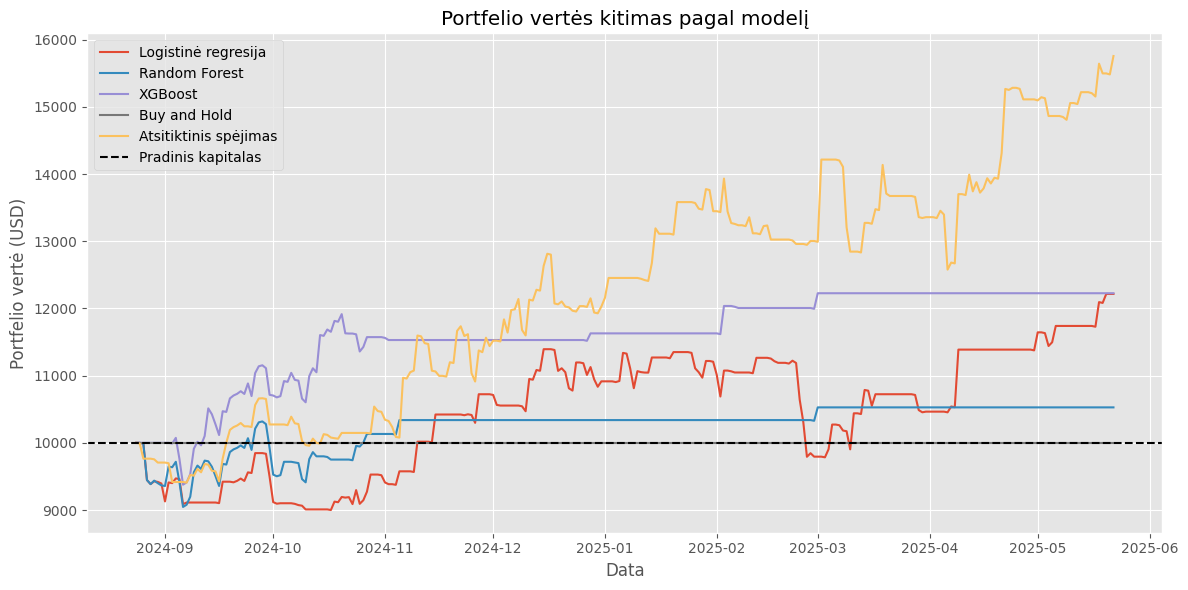

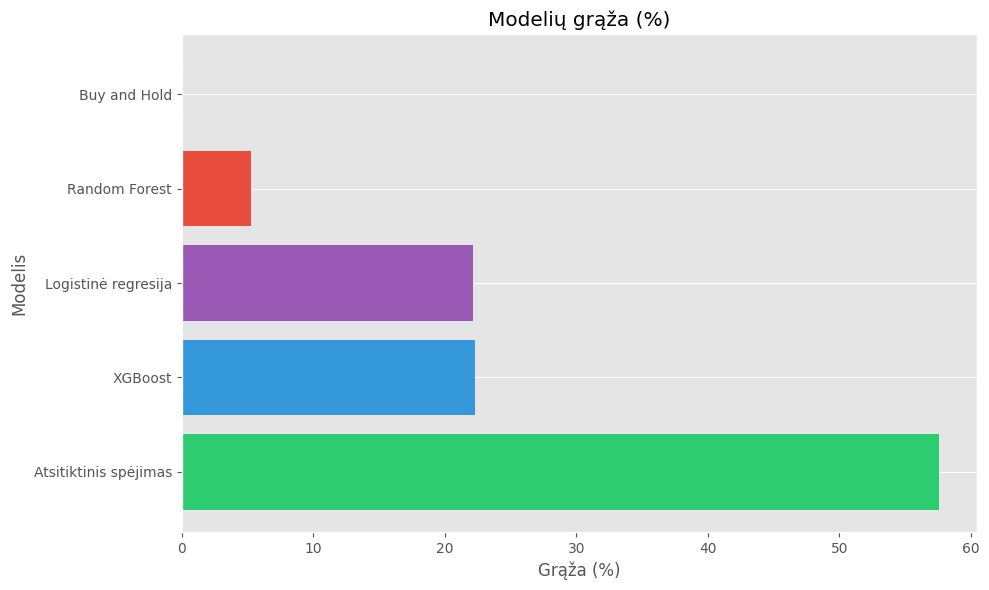

Modelių prekybos rezultatų palyginimas:
              Modelis  Galutinė vertė ($)  Grąža (%)  Metinė grąža (%)  Sandorių skaičius  Sėkmingų sandorių (%)  Max drawdown (%)  Sharpe rodiklis
Atsitiktinis spėjimas        15756.107032  57.561070         84.552056                126              55.555556         11.519237         1.632038
              XGBoost        12226.400989  22.264010         31.117263                 24              66.666667          6.913693         1.438021
  Logistinė regresija        12215.961108  22.159611         30.966390                 92              58.695652         14.121723         0.919737
        Random Forest        10527.762370   5.277624          7.177654                 22              72.727273          9.537469         0.423265
         Buy and Hold        10000.000000   0.000000          0.000000                  0               0.000000          0.000000         0.000000


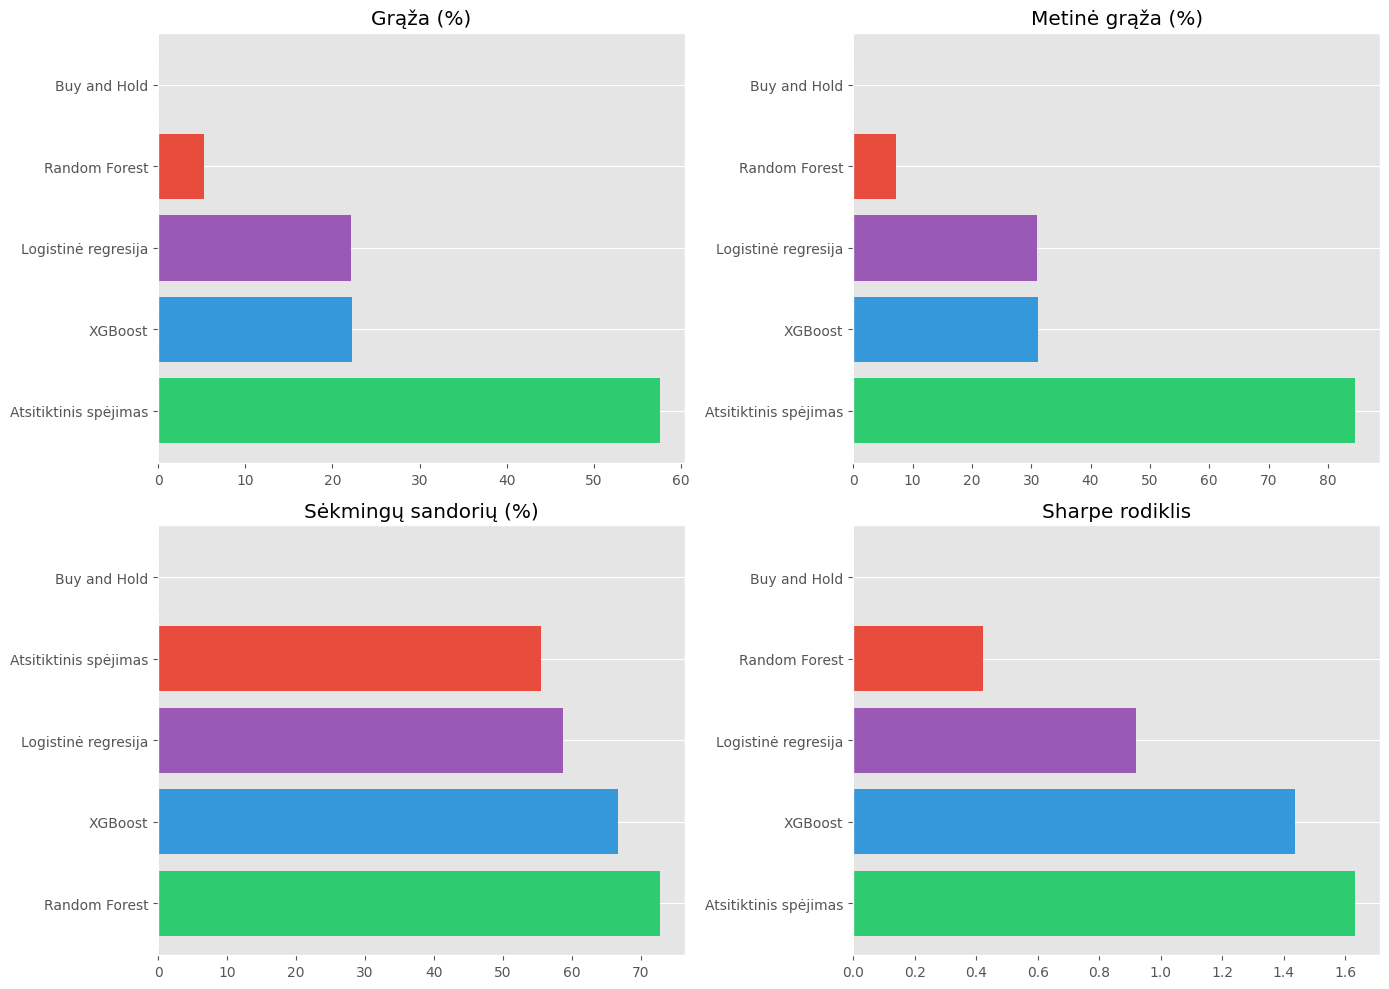

In [7]:
# 7. Grafinis rezultatų vizualizavimas

# 7.1 Portfelio verčių grafikas
plt.figure(figsize=(12, 6))

for modelio_pavadinimas, rezultatai in trading_results.items():
    plt.plot(rezultatai.index, rezultatai['portfelio_verte'], label=modelio_pavadinimas)

plt.axhline(y=10000, color='black', linestyle='--', label='Pradinis kapitalas')
plt.title('Portfelio vertės kitimas pagal modelį')
plt.xlabel('Data')
plt.ylabel('Portfelio vertė (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.2 Grąžos palyginimo grafikas
plt.figure(figsize=(10, 6))

galutines_vertes = [metrikos[modelis]['galutine_verte'] for modelis in metrikos]
pelno_procentai = [metrikos[modelis]['pelno_procentas'] for modelis in metrikos]

# Surūšiuojame modelius pagal pelno procentą
indeksai = np.argsort(pelno_procentai)[::-1]  # Nuo didžiausio iki mažiausio
surusiuoti_modeliai = [list(metrikos.keys())[i] for i in indeksai]
surusiuoti_pelno_procentai = [pelno_procentai[i] for i in indeksai]

spalvos = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
spalvos = spalvos[:len(surusiuoti_modeliai)]

plt.barh(surusiuoti_modeliai, surusiuoti_pelno_procentai, color=spalvos)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Modelių grąža (%)')
plt.xlabel('Grąža (%)')
plt.ylabel('Modelis')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 7.3 Pagrindinių metrikų palyginimas
metriku_df = pd.DataFrame({
    'Modelis': list(metrikos.keys()),
    'Galutinė vertė ($)': [metrikos[m]['galutine_verte'] for m in metrikos],
    'Grąža (%)': [metrikos[m]['pelno_procentas'] for m in metrikos],
    'Metinė grąža (%)': [metrikos[m]['metine_graza_proc'] for m in metrikos],
    'Sandorių skaičius': [metrikos[m]['sandoriu_skaicius'] for m in metrikos],
    'Sėkmingų sandorių (%)': [metrikos[m]['sekmingu_sandoriu_proc'] for m in metrikos],
    'Max drawdown (%)': [metrikos[m]['max_drawdown_proc'] for m in metrikos],
    'Sharpe rodiklis': [metrikos[m]['sharpe_rodiklis'] for m in metrikos]
})

# Surūšiuojame pagal grąžą (nuo didžiausios iki mažiausios)
metriku_df = metriku_df.sort_values('Grąža (%)', ascending=False)

print("Modelių prekybos rezultatų palyginimas:")
print(metriku_df.to_string(index=False))

# 7.4 Pagrindinių metrikų vizualizacija
metrics_to_plot = ['Grąža (%)', 'Metinė grąža (%)', 'Sėkmingų sandorių (%)', 'Sharpe rodiklis']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    # Surūšiuojame modelius pagal metriką (nuo didžiausios iki mažiausios)
    df_sorted = metriku_df.sort_values(metric, ascending=False)
    
    ax.barh(df_sorted['Modelis'], df_sorted[metric], color=spalvos[:len(df_sorted)])
    ax.set_title(metric)
    ax.axvline(x=0, color='black', linestyle='--')
    ax.grid(axis='x')

plt.tight_layout()
plt.show()

Geriausias modelis pagal grąžą: Atsitiktinis spėjimas

Geriausio modelio sandorių analizė:
Pelningiausi sandoriai:
pirkimo_data pardavimo_data  pirkimo_kaina  pardavimo_kaina      pelnas  pelnas_proc
  2025-04-20     2025-04-22       85179.24         93442.99 1336.212391     9.591899
  2025-03-01     2025-03-02       86064.53         94270.00 1224.345212     9.424556
  2024-11-05     2024-11-06       69372.01         75571.99  889.736574     8.828356
  2025-04-08     2025-04-09       76322.42         82615.22 1030.935142     8.136777
  2024-09-15     2024-09-23       59132.00         63339.99  671.121998     7.009149

Nuostolingiausi sandoriai:
pirkimo_data pardavimo_data  pirkimo_kaina  pardavimo_kaina       pelnas  pelnas_proc
  2024-09-29     2024-09-30       65602.01         63327.59  -379.625508    -3.563530
  2024-10-31     2024-11-04       70292.01         67850.01  -373.549777    -3.570605
  2025-04-03     2025-04-07       83213.09         79163.24  -662.171816    -4.961976
  2

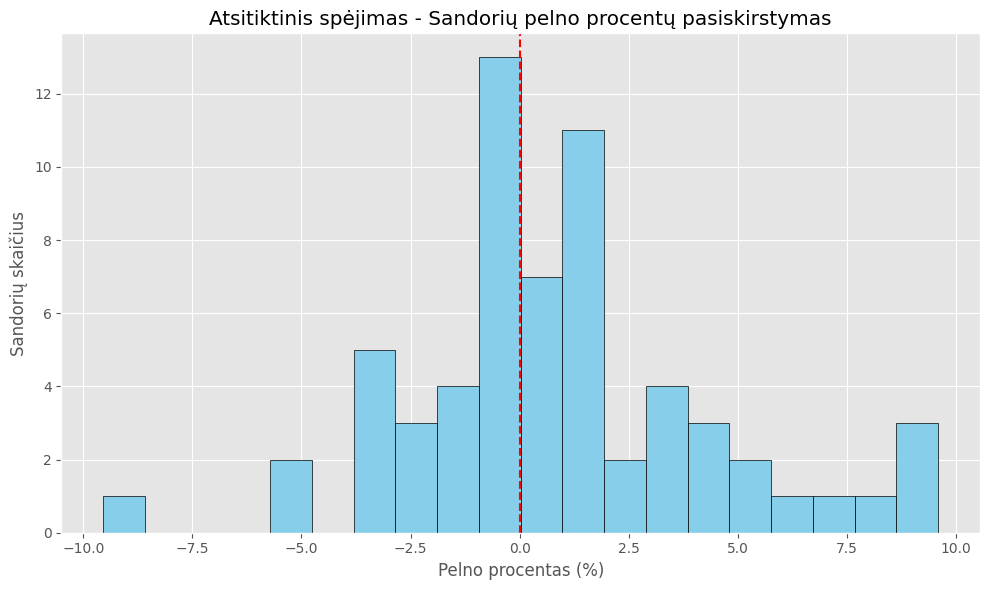

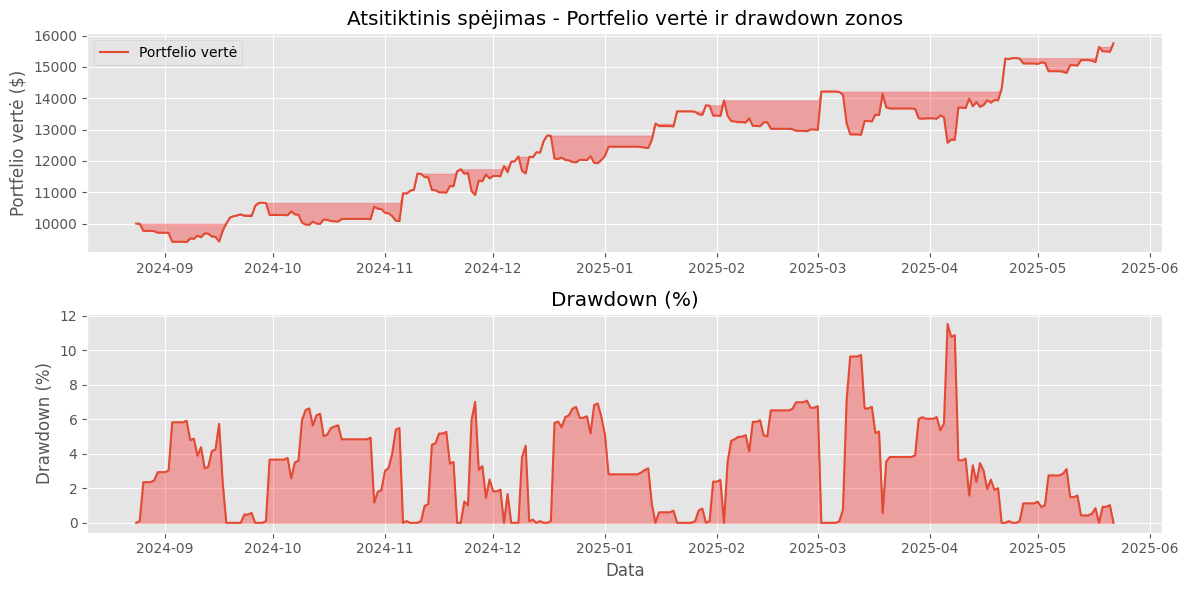

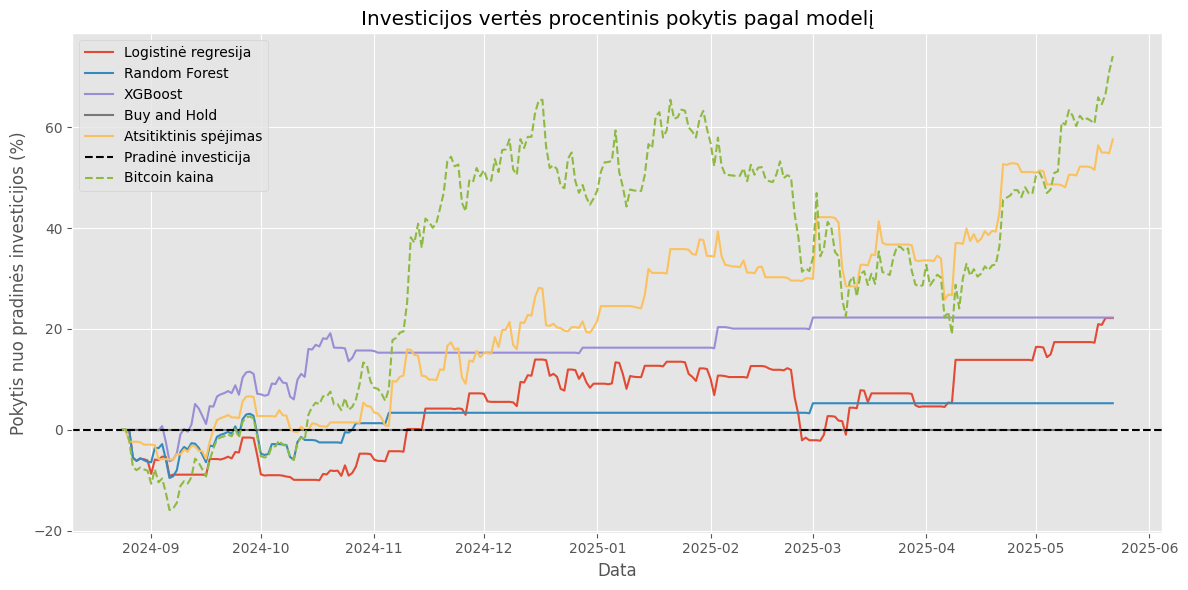

In [8]:
# 8. Detalus modelių prekybos analizė

# Nustatome geriausią modelį pagal grąžą
geriausias_modelis = metriku_df.iloc[0]['Modelis']
print(f"Geriausias modelis pagal grąžą: {geriausias_modelis}")

# Giliesnė geriausio modelio analizė
geriausio_rezultatai = trading_results[geriausias_modelis]
geriausio_metrikos = metrikos[geriausias_modelis]

# 8.1 Sandorių analizė
if len(geriausio_metrikos['sandoriu_poros']) > 0:
    poros_df = pd.DataFrame(geriausio_metrikos['sandoriu_poros'])
    
    # Surūšiuojame poras pagal pelno procentą
    poros_df = poros_df.sort_values('pelnas_proc', ascending=False)
    
    print("\nGeriausio modelio sandorių analizė:")
    print(f"Pelningiausi sandoriai:")
    print(poros_df.head().to_string(index=False))
    
    print(f"\nNuostolingiausi sandoriai:")
    print(poros_df.tail().to_string(index=False))
    
    # Sandorių pelno histograma
    plt.figure(figsize=(10, 6))
    plt.hist(poros_df['pelnas_proc'], bins=20, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'{geriausias_modelis} - Sandorių pelno procentų pasiskirstymas')
    plt.xlabel('Pelno procentas (%)')
    plt.ylabel('Sandorių skaičius')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nGeriausias modelis neatliko sandorių.")

# 8.2 Drawdown analizė
portfelio_vertes = geriausio_rezultatai['portfelio_verte'].values
max_iki_siol = np.maximum.accumulate(portfelio_vertes)
drawdowns = 1 - portfelio_vertes / max_iki_siol

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(geriausio_rezultatai.index, geriausio_rezultatai['portfelio_verte'], label='Portfelio vertė')
plt.fill_between(geriausio_rezultatai.index, max_iki_siol, portfelio_vertes, alpha=0.3, color='red')
plt.title(f'{geriausias_modelis} - Portfelio vertė ir drawdown zonos')
plt.ylabel('Portfelio vertė ($)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(geriausio_rezultatai.index, drawdowns * 100)
plt.fill_between(geriausio_rezultatai.index, 0, drawdowns * 100, alpha=0.3, color='red')
plt.title('Drawdown (%)')
plt.xlabel('Data')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.3 Pradinės investicijos augimo palyginimas
plt.figure(figsize=(12, 6))

for modelio_pavadinimas, rezultatai in trading_results.items():
    # Apskaičiuojame portfelio vertės procentinį pokytį nuo pradžios
    pradine_verte = 10000
    rezultatai['verte_proc'] = (rezultatai['portfelio_verte'] / pradine_verte - 1) * 100
    plt.plot(rezultatai.index, rezultatai['verte_proc'], label=modelio_pavadinimas)

plt.axhline(y=0, color='black', linestyle='--', label='Pradinė investicija')

# Taip pat pridedame Bitcoin kainos pokytį palyginimui
btc_kainos = testavimo_duomenys['kaina']
pradine_btc_kaina = btc_kainos.iloc[0]
btc_pokytis = (btc_kainos / pradine_btc_kaina - 1) * 100
plt.plot(btc_kainos.index, btc_pokytis, label='Bitcoin kaina', linestyle='--')

plt.title('Investicijos vertės procentinis pokytis pagal modelį')
plt.xlabel('Data')
plt.ylabel('Pokytis nuo pradinės investicijos (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# 9. Detali ataskaita apie modelių efektyvumą prekyboje

ataskaita = f"""
# Bitcoin Kainų Prognozavimo Modelių Prekybos Rezultatų Ataskaita

## Įvadas

Šioje ataskaitoje pateikiami įvairių mašininio mokymosi modelių, naudojamų Bitcoin kainų prognozavimui, 
prekybos simuliacijos rezultatai ir analizė. Buvo analizuojami šie modeliai:

1. Logistinė regresija
2. Random Forest
3. XGBoost
4. Buy and Hold strategija (bazinis modelis, visada spėja "kils")
5. Atsitiktinis spėjimas

## Testavimo sąlygos

- Pradinis kapitalas: $10,000
- Testavimo laikotarpis: {X_test.index[0].strftime('%Y-%m-%d')} - {X_test.index[-1].strftime('%Y-%m-%d')} ({len(X_test)} dienos)
- Komisinis mokestis: 0.1% nuo kiekvieno sandorio vertės
- Prekybos strategija: Pirkimas, kai signalas keičiasi į "kils", pardavimas, kai signalas keičiasi į "kris"

## Pagrindiniai rezultatai

Geriausią prekybos rezultatą parodė **{geriausias_modelis}** modelis:
- Galutinė portfelio vertė: ${metrikos[geriausias_modelis]['galutine_verte']:.2f}
- Bendras pelnas: ${metrikos[geriausias_modelis]['bendras_pelnas']:.2f} ({metrikos[geriausias_modelis]['pelno_procentas']:.2f}%)
- Metinė grąža: {metrikos[geriausias_modelis]['metine_graza_proc']:.2f}%
- Sharpe rodiklis: {metrikos[geriausias_modelis]['sharpe_rodiklis']:.2f}

## Modelių palyginimas

| Modelis | Galutinė vertė ($) | Grąža (%) | Metinė grąža (%) | Sandorių skaičius | Sėkmingų sandorių (%) | Max drawdown (%) | Sharpe rodiklis |
|---------|-------------------|----------|-----------------|-------------------|----------------------|-----------------|----------------|
{metriku_df.to_string(index=False)}

## Išvados

1. **Efektyviausi modeliai:** {', '.join(metriku_df['Modelis'].iloc[:2].tolist())} parodė geriausius rezultatus prekyboje.

2. **Tikslumas vs. Pelningumas:** Nors modelio tikslumas yra svarbus, jis ne visada tiesiogiai koreliuoja su 
   prekybos pelningumu. {metriku_df['Modelis'].iloc[0]} modelis, kurio tikslumas buvo {models[metriku_df['Modelis'].iloc[0]]['accuracy']:.4f}, 
   generavo didžiausią grąžą.

3. **Sandorių dažnumas:** Modeliai atliko skirtingą kiekį sandorių: mažiausiai - {metriku_df['Sandorių skaičius'].min()}, 
   daugiausiai - {metriku_df['Sandorių skaičius'].max()}. Optimalus sandorių skaičius priklauso nuo modelio gebėjimo 
   tiksliai prognozuoti kainų pokyčius.

4. **Rizikos valdymas:** Modeliai pasižymėjo skirtingais maksimalaus nuosmukio (drawdown) rodikliais. Mažiausias drawdown
   buvo {metriku_df['Max drawdown (%)'].min():.2f}%, didžiausias - {metriku_df['Max drawdown (%)'].max():.2f}%.

5. **Palyginimas su HODL:** {'Buy and Hold strategija parodė geresnius rezultatus nei sudėtingesni modeliai.' if 'Buy and Hold' in metriku_df['Modelis'].iloc[:2].tolist() else 'Mašininio mokymosi modeliai parodė geresnius rezultatus nei paprasta Buy and Hold strategija.'}

## Rekomendacijos

1. Tolesniam darbui rekomenduojama naudoti {geriausias_modelis} modelį, kuris parodė geriausius rezultatus.
2. Verta ištirti modelių derinimo galimybes, pvz., ansamblinio mokymosi metodus.
3. Tobulinti prekybos strategiją, įvedant rizikos valdymo priemones, pvz., stop-loss ir take-profit.
4. Įtraukti daugiau išorinių kintamųjų (rinkos sentimentas, ekonominiai rodikliai), kurie galėtų pagerinti prognozes.

"""

print(ataskaita)


# Bitcoin Kainų Prognozavimo Modelių Prekybos Rezultatų Ataskaita

## Įvadas

Šioje ataskaitoje pateikiami įvairių mašininio mokymosi modelių, naudojamų Bitcoin kainų prognozavimui, 
prekybos simuliacijos rezultatai ir analizė. Buvo analizuojami šie modeliai:

1. Logistinė regresija
2. Random Forest
3. XGBoost
4. Buy and Hold strategija (bazinis modelis, visada spėja "kils")
5. Atsitiktinis spėjimas

## Testavimo sąlygos

- Pradinis kapitalas: $10,000
- Testavimo laikotarpis: 2024-08-24 - 2025-05-22 (272 dienos)
- Komisinis mokestis: 0.1% nuo kiekvieno sandorio vertės
- Prekybos strategija: Pirkimas, kai signalas keičiasi į "kils", pardavimas, kai signalas keičiasi į "kris"

## Pagrindiniai rezultatai

Geriausią prekybos rezultatą parodė **Atsitiktinis spėjimas** modelis:
- Galutinė portfelio vertė: $15756.11
- Bendras pelnas: $5756.11 (57.56%)
- Metinė grąža: 84.55%
- Sharpe rodiklis: 1.63

## Modelių palyginimas

| Modelis | Galutinė vertė ($) | Grąža (%) | Metinė grąža (%) | Sandor

In [10]:
# 10. Modelių išsaugojimas

# Išsaugojame visus apmokytus modelius
for modelio_pavadinimas, modelio_info in models.items():
    if modelio_info['model'] is not None:  # Išsaugome tik tuos modelius, kurie buvo apmokyti
        model_path = os.path.join(models_dir, f"{modelio_pavadinimas.lower().replace(' ', '_')}_modelis.pkl")
        joblib.dump(modelio_info['model'], model_path)
        print(f"Modelis išsaugotas: {model_path}")

# Išsaugome prekybos rezultatus CSV formatu
rezultatai_dir = os.path.join(models_dir, 'prekybos_rezultatai')
if not os.path.exists(rezultatai_dir):
    os.makedirs(rezultatai_dir)

for modelio_pavadinimas, rezultatai in trading_results.items():
    result_path = os.path.join(rezultatai_dir, f"{modelio_pavadinimas.lower().replace(' ', '_')}_rezultatai.csv")
    rezultatai.to_csv(result_path)
    print(f"Prekybos rezultatai išsaugoti: {result_path}")

# Išsaugome metrikų DataFrame
metriku_path = os.path.join(rezultatai_dir, 'modeliu_metrikos.csv')
metriku_df.to_csv(metriku_path, index=False)
print(f"Modelių metrikos išsaugotos: {metriku_path}")

# Išsaugome ataskaitą tekstiniu formatu
ataskaitos_path = os.path.join(rezultatai_dir, 'prekybos_rezultatu_ataskaita.md')
with open(ataskaitos_path, 'w', encoding='utf-8') as f:
    f.write(ataskaita)
print(f"Ataskaita išsaugota: {ataskaitos_path}")

print("\nModelių vertinimas ir prekybos rezultatų analizė sėkmingai užbaigta!")

Modelis išsaugotas: ../../models\logistinė_regresija_modelis.pkl
Modelis išsaugotas: ../../models\random_forest_modelis.pkl
Modelis išsaugotas: ../../models\xgboost_modelis.pkl
Prekybos rezultatai išsaugoti: ../../models\prekybos_rezultatai\logistinė_regresija_rezultatai.csv
Prekybos rezultatai išsaugoti: ../../models\prekybos_rezultatai\random_forest_rezultatai.csv
Prekybos rezultatai išsaugoti: ../../models\prekybos_rezultatai\xgboost_rezultatai.csv
Prekybos rezultatai išsaugoti: ../../models\prekybos_rezultatai\buy_and_hold_rezultatai.csv
Prekybos rezultatai išsaugoti: ../../models\prekybos_rezultatai\atsitiktinis_spėjimas_rezultatai.csv
Modelių metrikos išsaugotos: ../../models\prekybos_rezultatai\modeliu_metrikos.csv
Ataskaita išsaugota: ../../models\prekybos_rezultatai\prekybos_rezultatu_ataskaita.md

Modelių vertinimas ir prekybos rezultatų analizė sėkmingai užbaigta!
